# SPEML - Assignment 1
---
This exercise is intended for group work of 2 students. Only one student per group needs to submit the report - when you are signed up to a group, the submission will also be visible to the second group member.

Synthetic Data Creation and Evaluation
In this task, you will work with a synthetic data generation tool, and evaluate fidelity, utility and privacy aspects of the synthetic data; to keep computation times reasonable, you shall work with tabular data. The idea is that you use existing tools, and mainly develop the boilerplate code around using these tools (dataset loading, spitting, model training, calling evaluation tools, ....).

The exercise thus consists of roughly the following steps:

Pick a tabular dataset from a public repository; ideally, the dataset contains some sensitive/personal attributes (age, income, education, a diagnosis, ....). Overall, your dataset does not need to be too large, anything from 1k samples up should be fine.
(we focus on tabular data due to computational costs / runtime, interpretability of the results, and the meaningfulness of fidelity & privacy evaluation; if you would want to work with some other data modality, contact me, we can discuss if that is feasible)

Chose a data synthetisation framework; while there are many frameworks around, we can recommend the [Synthetic Data Vault](https://github.com/sdv-dev/SDV) (SDV) as a very comprehensive tool including many different techniques (their original Gaussian Copula, but also CTGAN, and implementations of Bayesian Networks, ...) , gretel.ai; synthpop offers decision trees (primary implementation is in R), DataSynthesizer offers Bayesian Networks. You can find a curated list e.g. at https://github.com/joofio/awesome-data-synthesis

Prepare your data for evaluation; basically, you shall have a test set available for testing classifiers

Create a synthetic data version from your original training data; for simplicity reasons, just create a dataset with the same number of samples as the original dataset.

Perform a fidelity evaluation of the synthetic dataset, by comparing data characteristics to the original training data; you can utilise e.g. the SDMetric from the SDV https://github.com/sdv-dev/SDMetrics; select the most interesting aspects from the evaluation for your report.

Perform a utility evaluation of the synthetic dataset, by training one classifier model, once on the original training data, and once on the synthetic data; then evaluate both models on the test data, and compare their performance. Use a fast, shallow, but still powerful model (e.g. SVM, RF, Boosting algorithms, ....)

Perform a privacy evaluation of the synthetic dataset, by using a privacy evaluation tool. You can use e.g. Anonymeter (https://github.com/statice/anonymeter), and focus on metrics that can be computed from the synthetic data directly. There are other tools around, but many of them provide attack-based evaluation (e.g. membership inference attacks), which are computationally expensive. Again, select the most interesting aspects from the evaluation for your report.

Write up all of this in a short report; in the report, describe what tools and parameter settings you used, and describe and discuss the results in terms of fidelity, utility and privacy of the synthetic data. Submit a complete package including your report, your code, and your data files (original and generated).

To avoid everyone using the same dataset, you shall register your dataset on the wiki page, and make sure that each dataset is used at most by three groups.

## Packages
The following packages are used in this project

In [18]:
! pip install -r ./requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 6.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 5.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
  Attempting uninstall: numba
    Found existing installation: numba 0.56.4
    Uninstalling numba-0.56.4:
      Successfully uninstalled numba-0.56.4


## General data
### Imports

In [1]:
import numpy as np
import pandas as pd

from utils import train_and_evaluate

In [2]:
# define a random state
random_state = 12014500

# set the random state
np.random.seed(random_state)

## Dataset
We work with the compass dataset...

In [3]:
file_path = './data/compas-scores-raw.csv'
df = pd.read_csv(file_path)

In [4]:
display(df.head())

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [5]:
df.dtypes

Person_ID                    int64
AssessmentID                 int64
Case_ID                      int64
Agency_Text                 object
LastName                    object
FirstName                   object
MiddleName                  object
Sex_Code_Text               object
Ethnic_Code_Text            object
DateOfBirth                 object
ScaleSet_ID                  int64
ScaleSet                    object
AssessmentReason            object
Language                    object
LegalStatus                 object
CustodyStatus               object
MaritalStatus               object
Screening_Date              object
RecSupervisionLevel          int64
RecSupervisionLevelText     object
Scale_ID                     int64
DisplayText                 object
RawScore                   float64
DecileScore                  int64
ScoreText                   object
AssessmentType              object
IsCompleted                  int64
IsDeleted                    int64
dtype: object

In [6]:
df.columns

Index(['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName',
       'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text',
       'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason',
       'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus',
       'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
       'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
       'AssessmentType', 'IsCompleted', 'IsDeleted'],
      dtype='object')

In [7]:
nominal_features = ['Agency_Text', 'Ethnic_Code_Text', 'AssessmentReason', 'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus', 'RecSupervisionLevel']

In the following code snippet, we do some small preprocessing. First we drop some redundant and unnecessary attributes. For example IDs that are unique to the person or the case should be ignored, because they do not represent any important information, other than identifying this person. Furthermore, we remove the name from the data, because this not only instantly allows to know, who the records belong to and it isn't important when training a simple model. Futhermore, we convert the date to timestamps and remove all other possible "target" attributes

### PreProcessing

In [8]:
columns_to_drop = ['Person_ID', 'AssessmentID', 'Case_ID', 'LastName', 'FirstName', 'MiddleName', 'ScaleSet', 'RecSupervisionLevelText', 'DisplayText', 'RawScore', 'DecileScore', 'AssessmentType', 'IsCompleted', 'IsDeleted'] 

df = df.drop(columns_to_drop, axis=1)
df['Sex_Code_Text'] = df['Sex_Code_Text'].apply(lambda x: 1 if x == 'Male' else 0)
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth']).astype(int) // 10**9  # Convert to Unix timestamp
df['Screening_Date'] = pd.to_datetime(df['Screening_Date']).astype(int) // 10**9  # Convert to Unix timestamp

df = df.dropna(subset=['ScoreText'])

In [9]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)

In [10]:
# Replace '?' with NaN, if necessary (check those special characters)
df_train.replace('NaN', np.nan, inplace=True)
df_test.replace('NaN', np.nan, inplace=True)

## Baseline Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, df_train, df_test, nominal_features)

Accuracy: 0.84%


## Data synthetization

In [12]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import CopulaGANSynthesizer

from utils import generate_synthetic_data, evaluate_privacy_risks, evaluate_inference_risks

### Metadata

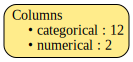

In [16]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_train)

metadata.visualize(
    show_table_details='summarized',
    output_filepath='my_metadata.png'
)

In [17]:
metadata.validate_data(data=df_train)

### GaussianCopulaSynthesizer

In [14]:
synthetic_data_gc = generate_synthetic_data(GaussianCopulaSynthesizer(metadata), df_train)

/Users/maxkleinegger/anaconda3/lib/python3.10/site-packages/sdv/single_table/base.py:82: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [18]:
display(synthetic_data_gc.head())

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,Scale_ID,ScoreText
0,PRETRIAL,1,African-American,574380990,22,Intake,English,Pretrial,Jail Inmate,Single,1382863472,1,18,Medium
1,PRETRIAL,1,African-American,126230400,22,Intake,English,Post Sentence,Probation,Married,1369853627,1,18,High
2,Probation,1,Caucasian,1570672035,22,Intake,English,Post Sentence,Pretrial Defendant,Divorced,1404042308,1,8,Low
3,PRETRIAL,1,African-American,126230400,22,Intake,English,Post Sentence,Probation,Single,1380261283,2,18,High
4,PRETRIAL,0,Caucasian,2443303261,22,Intake,English,Post Sentence,Probation,Single,1397265981,1,18,Low


In [22]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic_report = run_diagnostic(
    real_data=df_train,
    synthetic_data=synthetic_data_gc,
    metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 321.30it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 310.67it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [23]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=df_train,
    synthetic_data=synthetic_data_gc,
    metadata=metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 86.89it/s]|
Column Shapes Score: 97.12%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:02<00:00, 31.95it/s]|
Column Pair Trends Score: 70.49%

Overall Score (Average): 83.8%



In [24]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,Agency_Text,TVComplement,0.997163
1,Sex_Code_Text,TVComplement,0.996299
2,Ethnic_Code_Text,TVComplement,0.998931
3,DateOfBirth,KSComplement,0.647806
4,ScaleSet_ID,TVComplement,0.999836
5,AssessmentReason,TVComplement,1.000000
6,Language,TVComplement,0.999692
7,LegalStatus,TVComplement,0.997122
8,CustodyStatus,TVComplement,0.997718
9,MaritalStatus,TVComplement,0.997821


In [25]:
quality_report.get_visualization(property_name='Column Pair Trends')

#### Classifier

In [19]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_gc, df_test, nominal_features)

Accuracy: 0.68%


In [20]:
evaluate_privacy_risks(df_train, synthetic_data_gc)

/Users/maxkleinegger/anaconda3/lib/python3.10/site-packages/anonymeter/stats/confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.0019133792427775617, baseline = 0.0019133792427775617. Analysis results cannot be trusted.
  self._sanity_check()


Privacy risks concerning the univariate attacks (1 col): $PrivacyRisk(value=0.0019133792427775617, ci=(0.0, 0.0038267584855551234))
Privacy risks concerning the multivariate attacks ($14 col): $PrivacyRisk(value=0.024825363797609797, ci=(0.015374276932992922, 0.034276450662226676))


/Users/maxkleinegger/anaconda3/lib/python3.10/site-packages/anonymeter/stats/confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.9263621473681823, baseline = 0.9363238797833268. Analysis results cannot be trusted.
  self._sanity_check()
/Users/maxkleinegger/anaconda3/lib/python3.10/site-packages/anonymeter/stats/confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.9980866207572224, baseline = 0.9980866207572224. Analysis results cannot be trusted.
  self._sanity_check()
/Users/maxkleinegger/anaconda3/lib/python3.10/site-packages/anonymeter/stats/confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.9980866207572224, baseline = 0.9980866207572224. Analysis results cannot be trusted.
  self._sanity_check()
/Users/maxkleinegger/anaconda3/lib/python3.10/site-packages/anonymeter/stats/confidence.py:218: UserWarning: Attack is as good 

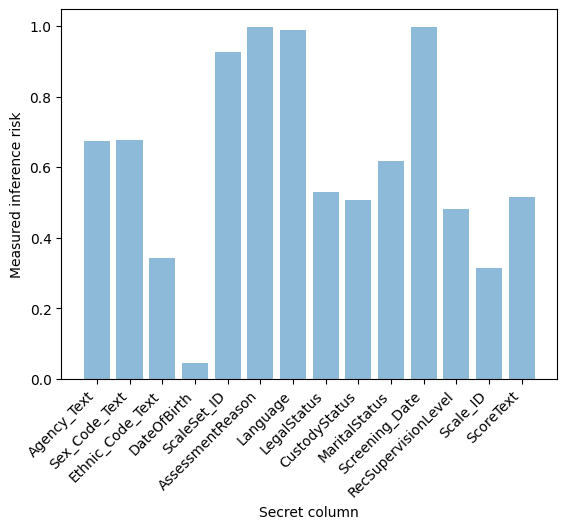

In [21]:
evaluate_inference_risks(df_train, synthetic_data_gc)

### CTGANSynthesizer

In [58]:
synthesizer_ctgan = CTGANSynthesizer(metadata, epochs=200, verbose=True)
synthesizer_ctgan.fit(df_train)

synthetic_data_ctgan = synthesizer_ctgan.sample(num_rows=len(df_train))

Gen. (-1.76) | Discrim. (-0.24): 100%|██████████| 200/200 [10:11<00:00,  3.06s/it]


In [59]:
display(synthetic_data_ctgan.head())

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,Scale_ID,ScoreText
0,PRETRIAL,Male,African-American,3083589624,22,Intake,English,Pretrial,Probation,Married,1369844811,1,7,Low
1,PRETRIAL,Male,Native American,3120306771,22,Intake,English,Pretrial,Pretrial Defendant,Married,1362471562,1,18,Low
2,Probation,Male,Caucasian,692416916,22,Intake,English,Post Sentence,Probation,Married,1377745723,3,8,Medium
3,PRETRIAL,Male,African-American,622767518,22,Intake,English,Pretrial,Pretrial Defendant,Married,1370277698,1,7,Low
4,PRETRIAL,Male,African-American,3034402793,22,Intake,English,Pretrial,Jail Inmate,Unknown,1416264499,1,18,Low


#### Classifier

In [60]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_ctgan, df_test)

Accuracy: 0.7552631578947369%


### CopulaGANSynthesizer

In [61]:
synthesizer_tvae = CopulaGANSynthesizer(metadata, epochs=200, verbose=True)
synthesizer_tvae.fit(df_train)

synthetic_data_tvae = synthesizer_tvae.sample(num_rows=len(df_train))

Gen. (-1.31) | Discrim. (-0.18): 100%|██████████| 200/200 [12:11<00:00,  3.66s/it]


In [62]:
display(synthetic_data_tvae.head())

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,Scale_ID,ScoreText
0,Probation,Male,Caucasian,2799653771,22,Intake,English,Post Sentence,Probation,Married,1357019144,1,7,Low
1,PRETRIAL,Female,Native American,451822190,22,Intake,English,Pretrial,Pretrial Defendant,Single,1387839313,1,18,Low
2,Probation,Female,Caucasian,827719971,22,Intake,English,Post Sentence,Probation,Single,1406086151,1,8,Low
3,PRETRIAL,Male,Hispanic,596773614,22,Intake,English,Pretrial,Jail Inmate,Divorced,1410770343,1,8,Medium
4,PRETRIAL,Male,Hispanic,2781048197,22,Intake,English,Pretrial,Jail Inmate,Unknown,1398808805,1,18,Low


#### Classifier

In [63]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_tvae, df_test)

Accuracy: 0.7770559210526315%


### DataSynthesizer (correlated attribute mode)

In [66]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

In [99]:
file_path_preprocessed = './data/preprocessed_data.csv'
# location of two output files
mode = 'correlated_attribute_mode'
description_file = f'./out/{mode}/description.json'
synthetic_data = f'./out/{mode}/sythetic_data.csv'

In [72]:
threshold_value = 10

categorical_attributes = { col: True for col in df_train.columns if df_train[col].value_counts().shape[0] < threshold_value }

candidate_keys = {}
epsilon = 1

degree_of_bayesian_network = 2

num_tuples_to_generate = len(df_train) 

In [73]:
df_train.to_csv(file_path_preprocessed, index=False)

In [74]:
describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=file_path_preprocessed, 
                                                        epsilon=epsilon, 
                                                        k=degree_of_bayesian_network,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.save_dataset_description_to_file(description_file)

================ Constructing Bayesian Network (BN) ================
Adding ROOT ScoreText
Adding attribute RecSupervisionLevel
Adding attribute Scale_ID
Adding attribute DateOfBirth
Adding attribute MaritalStatus
Adding attribute Ethnic_Code_Text
Adding attribute LegalStatus
Adding attribute CustodyStatus
Adding attribute Agency_Text
Adding attribute Screening_Date
Adding attribute ScaleSet_ID
Adding attribute Language
Adding attribute Sex_Code_Text
Adding attribute AssessmentReason
========================== BN constructed ==========================


In [75]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    RecSupervisionLevel has parents ['ScoreText'].
    Scale_ID            has parents ['RecSupervisionLevel', 'ScoreText'].
    DateOfBirth         has parents ['Scale_ID', 'ScoreText'].
    MaritalStatus       has parents ['DateOfBirth', 'RecSupervisionLevel'].
    Ethnic_Code_Text    has parents ['MaritalStatus', 'RecSupervisionLevel'].
    LegalStatus         has parents ['Ethnic_Code_Text', 'DateOfBirth'].
    CustodyStatus       has parents ['LegalStatus', 'Scale_ID'].
    Agency_Text         has parents ['CustodyStatus', 'Ethnic_Code_Text'].
    Screening_Date      has parents ['CustodyStatus', 'Ethnic_Code_Text'].
    ScaleSet_ID         has parents ['CustodyStatus', 'Scale_ID'].
    Language            has parents ['Screening_Date', 'Scale_ID'].
    Sex_Code_Text       has parents ['ScaleSet_ID', 'CustodyStatus'].
    AssessmentReason    has parents ['CustodyStatus', 'MaritalStatus'].


In [76]:
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

In [100]:
synthetic_df = pd.read_csv(synthetic_data)
attribute_description = read_json_file(description_file)['attribute_description']

#### Classifier

In [101]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_df, df_test)

Accuracy: 0.84%


### DataSynthesizer (independent attribute mode)

In [79]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

In [106]:
file_path_preprocessed = './data/preprocessed_data.csv'

mode = 'independent_attribute_mode'
description_file = f'./out/{mode}/description.json'
synthetic_data = f'./out/{mode}/sythetic_data.csv'

In [127]:
threshold_value = 15

categorical_attributes = { col: True for col in df_train.columns if df_train[col].value_counts().shape[0] < threshold_value }

candidate_keys = {}

num_tuples_to_generate = len(df_train)

In [128]:
df_train.to_csv(file_path_preprocessed, index=False)

In [129]:
describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_independent_attribute_mode(dataset_file=file_path_preprocessed,
                                                         attribute_to_is_categorical=categorical_attributes,
                                                         attribute_to_is_candidate_key=candidate_keys)
describer.save_dataset_description_to_file(description_file)

In [130]:
generator = DataGenerator()
generator.generate_dataset_in_independent_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

In [131]:
synthetic_df = pd.read_csv(synthetic_data)
attribute_description = read_json_file(description_file)['attribute_description']

#### Classifier

In [ ]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_df, df_test, remove_diff_cols=False)

## Privacy check

In [19]:
from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator

In [21]:
evaluator = SinglingOutEvaluator(ori=df_train, 
                                 syn=synthetic_data_gc, 
                                 n_attacks=500,
                                 n_cols=len(df_train.columns))

try:
    evaluator.evaluate(mode='univariate')
    risk = evaluator.risk()
    print(risk)

    evaluator.evaluate(mode='multivariate')
    risk = evaluator.risk()
    print(risk)

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

/Users/maxkleinegger/anaconda3/lib/python3.10/site-packages/anonymeter/stats/confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.0038121702307761206, baseline = 0.0038121702307761206. Analysis results cannot be trusted.
  self._sanity_check()


PrivacyRisk(value=0.0038121702307761206, ci=(4.336808689942018e-19, 0.007624340461552241))
PrivacyRisk(value=0.039537693974160244, ci=(0.022891060980292727, 0.05618432696802776))


In [21]:
res = evaluator.results()

print("Successs rate of main attack:", res.attack_rate)
print("Successs rate of baseline attack:", res.baseline_rate)
print("Successs rate of control attack:", res.control_rate)

Successs rate of main attack: SuccessRate(value=0.0038121702307761206, error=0.00381217023077612)
Successs rate of baseline attack: SuccessRate(value=0.0038121702307761206, error=0.00381217023077612)
Successs rate of control attack: None


In [24]:
evaluator = SinglingOutEvaluator(ori=df_train, 
                                 syn=synthetic_data, 
                                 n_attacks=500, # this attack takes longer
                                 n_cols=len(df_train.columns))


try:
    evaluator.evaluate(mode='multivariate')
    risk = evaluator.risk()
    print(risk)

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

PrivacyRisk(value=0.027629186059698867, ci=(0.013781314655496982, 0.04147705746390075))


In [25]:
columns = df_train.columns
results = []

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    evaluator = InferenceEvaluator(ori=df_train, 
                                   syn=synthetic_data, 
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=1000)
    evaluator.evaluate(n_jobs=-2)
    results.append((secret, evaluator.results()))

/Users/maxkleinegger/anaconda3/lib/python3.10/site-packages/anonymeter/stats/confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.3396161081161744, baseline = 0.36551661239554994. Analysis results cannot be trusted.
  self._sanity_check()
/Users/maxkleinegger/anaconda3/lib/python3.10/site-packages/anonymeter/stats/confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.043752655386384245, baseline = 0.044748828627898696. Analysis results cannot be trusted.
  self._sanity_check()
/Users/maxkleinegger/anaconda3/lib/python3.10/site-packages/anonymeter/stats/confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.9173965881945524, baseline = 0.9233736276436391. Analysis results cannot be trusted.
  self._sanity_check()
/Users/maxkleinegger/anaconda3/lib/python3.10/site-packages/anonymeter/stats/confidence.py:218: UserWarning: Attack is as 

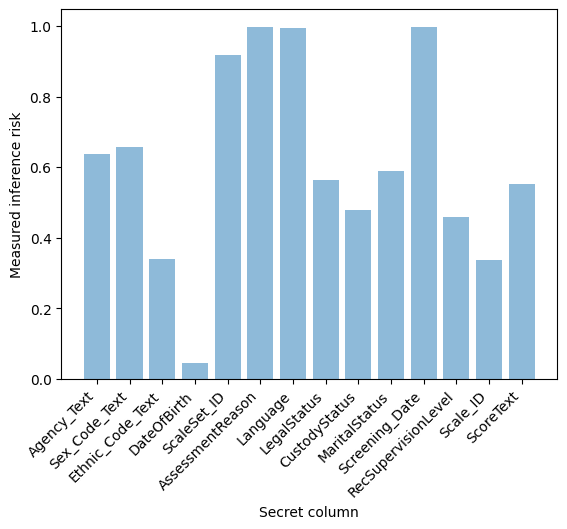

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")